In [1]:
# ! pip install seaborn==0.13.0
# ! pip install matplotlib==3.7.3

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1)

from utils import read_result, read_result_reverse

dataset_dict = {
    "dataset1": "1: SimSame",
    "dataset2": "2: SimDiff",
    "dataset3": "3: DisSame",
    "dataset4": "4: DisDiff",
}

FONTSIZE = 16
FIGSIZE = (9, 4)

# UnTrac

In [8]:
import os, glob

root = "unlearn_outputs"
dataset_names = [os.path.basename(p) for p in glob.glob(f"{root}/*") if os.path.isdir(p)]

missing = []
for n in dataset_names:
    p = os.path.join(root, n, "trainer_state.json")
    if os.path.isfile(p):
        print("OK     :", p)
    else:
        print("MISSING:", p)
        
        for alt in ("results.json", "metrics.json"):
            q = os.path.join(root, n, alt)
            if os.path.isfile(q):
                print("  found alt:", q)
                break
        else:
            missing.append(p)

assert not missing, "Still missing:\n" + "\n".join(missing)


OK     : unlearn_outputs/dataset4/trainer_state.json
OK     : unlearn_outputs/dataset3/trainer_state.json
OK     : unlearn_outputs/dataset1/trainer_state.json
OK     : unlearn_outputs/dataset2/trainer_state.json


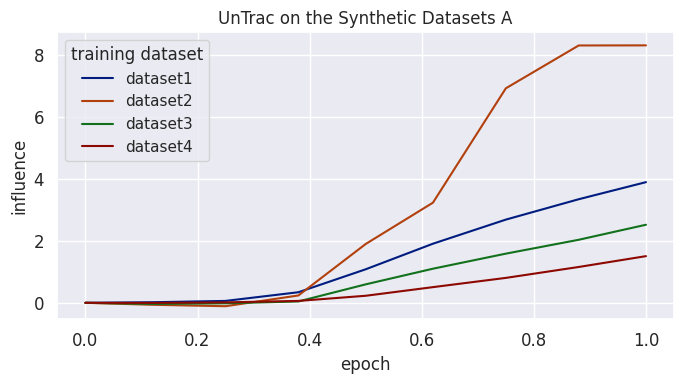

In [11]:
from utils import read_result
import os, glob, seaborn as sns, matplotlib.pyplot as plt

dataset_names = sorted(
    os.path.basename(p) for p in glob.glob("unlearn_outputs/*") if os.path.isdir(p)
)

df_result = read_result(
    output_dir_format="unlearn_outputs/{}/",  
    dataset_names=dataset_names,
    key_column="epoch",
    init_dir="model/t5_00",                  
)


dataset_dict = {name: name for name in dataset_names}

df_plot = df_result.copy()
df_plot["training dataset"] = df_plot.index.map(lambda n: dataset_dict.get(n, n))

FIGSIZE, FONTSIZE = (7, 4), 12
plt.figure(figsize=FIGSIZE)
ax = sns.lineplot(
    data=df_plot.reset_index(), 
    x="epoch", y="dataset0", hue="training dataset", palette="dark"
)
ax.set_title("UnTrac on the Synthetic Datasets A", fontsize=FONTSIZE)
ax.set_xlabel("epoch", fontsize=FONTSIZE)
ax.set_ylabel("influence", fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE); plt.yticks(fontsize=FONTSIZE);
plt.tight_layout()


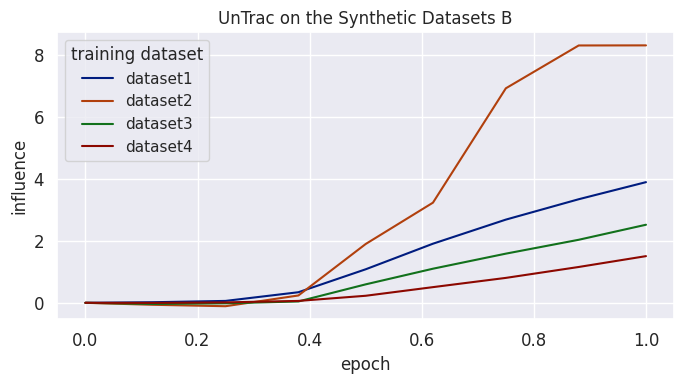

In [ ]:
from utils import read_result
import glob, os, seaborn as sns, matplotlib.pyplot as plt

ROOT = "unlearn_outputs"  
dataset_names = sorted(os.path.basename(p) for p in glob.glob(f"{ROOT}/*") if os.path.isdir(p))

df_result = read_result(
    output_dir_format=f"{ROOT}/{{}}/",
    dataset_names=dataset_names,
    key_column="epoch",
    init_dir="model/t5_00",  

df_plot = df_result.copy()
try:
    df_plot["training dataset"] = df_plot.index.map(lambda x: dataset_dict.get(x, x))
except NameError:
    df_plot["training dataset"] = df_plot.index

FIGSIZE, FONTSIZE = (7, 4), 12
plt.figure(figsize=FIGSIZE)
ax = sns.lineplot(
    data=df_plot, x="epoch", y="dataset0", hue="training dataset", palette="dark"
)
ax.set_title("UnTrac on the Synthetic Datasets B", fontsize=FONTSIZE)
ax.set_xlabel("epoch", fontsize=FONTSIZE)
ax.set_ylabel("influence", fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE); plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()


# UnTrac-Inv

In [ ]:
import os, glob

root = "untrac_inv_outputs"
dataset_names = [os.path.basename(p) for p in glob.glob(f"{root}/*") if os.path.isdir(p)]

missing = []
for n in dataset_names:
    p = os.path.join(root, n, "trainer_state.json")
    if os.path.isfile(p):
        print("OK     :", p)
    else:
        print("MISSING:", p)
        
        for alt in ("results.json", "metrics.json"):
            q = os.path.join(root, n, alt)
            if os.path.isfile(q):
                print("  found alt:", q)
                break
        else:
            missing.append(p)

assert not missing, "Still missing:\n" + "\n".join(missing)


OK     : untrac_inv_outputs/synthetic_train00_dataset/trainer_state.json
OK     : untrac_inv_outputs/synthetic_train10_dataset/trainer_state.json


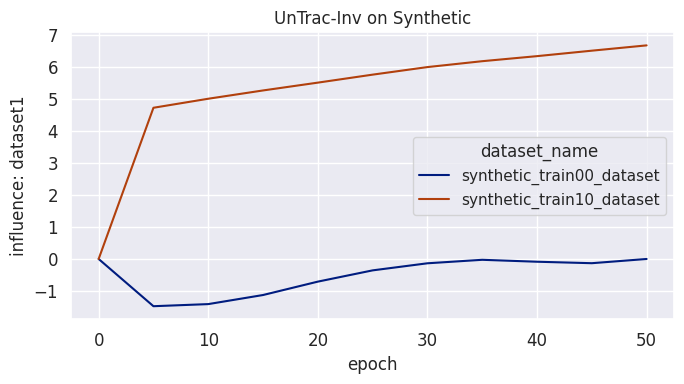

In [ ]:
from utils import read_result
import seaborn as sns, matplotlib.pyplot as plt

df_result = read_result(
    output_dir_format="untrac_inv_outputs/{}/",                    
    dataset_names=["synthetic_train00_dataset","synthetic_train10_dataset"],
    key_column="epoch",
    init_dir="untrac_inv_outputs/synthetic_train00_dataset",         
)

target_col = next(c for c in ["dataset1","dataset2","dataset3","dataset4","dataset0"] if c in df_result.columns)

FIGSIZE, FONTSIZE = (7,4), 12
plt.figure(figsize=FIGSIZE)
ax = sns.lineplot(data=df_result, x="epoch", y=target_col, hue=df_result.index.name or "run", palette="dark")
ax.set_title("UnTrac-Inv on Synthetic", fontsize=FONTSIZE)
ax.set_xlabel("epoch", fontsize=FONTSIZE); ax.set_ylabel(f"influence: {target_col}", fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE); plt.yticks(fontsize=FONTSIZE); plt.tight_layout()


In [17]:
last = (df_result.sort_values("epoch")
                  .groupby(level=0)[target_col]
                  .agg(['first','last']))
last["delta"] = last["last"] - last["first"]
display(last.sort_values("delta", ascending=False))


,first,last,delta
dataset_name,,,
synthetic_train10_dataset,0.0,6.665635,6.665635
synthetic_train00_dataset,0.0,0.000000,0.000000


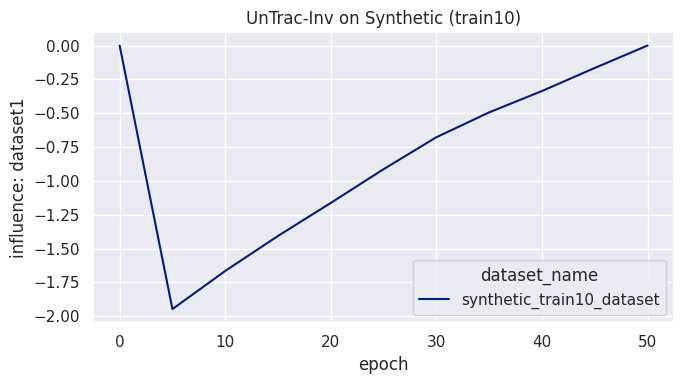

In [ ]:
from utils import read_result
import seaborn as sns, matplotlib.pyplot as plt

df_result = read_result(
    output_dir_format="untrac_inv_outputs/{}/",
    dataset_names=["synthetic_train10_dataset"],  
    key_column="epoch",
    init_dir="untrac_inv_outputs/synthetic_train10_dataset", 
)

target_col = next(c for c in ["dataset1","dataset2","dataset3","dataset4","dataset0"] if c in df_result.columns)

plt.figure(figsize=(7,4))
ax = sns.lineplot(data=df_result, x="epoch", y=target_col, hue=df_result.index.name or "run", palette="dark")
ax.set_title("UnTrac-Inv on Synthetic (train10)", fontsize=12)
ax.set_xlabel("epoch", fontsize=12); ax.set_ylabel(f"influence: {target_col}", fontsize=12)
plt.tight_layout()


In [19]:
last = (df_result.sort_values("epoch")
                  .groupby(level=0)[target_col]
                  .agg(['first','last']))
last["delta"] = last["last"] - last["first"]
display(last)


,first,last,delta
dataset_name,,,
synthetic_train10_dataset,0.0,0.0,0.0


In [10]:
import os

root = "model/t5_00_loo_00"
dataset_names = [d for d in os.listdir(root) if d != "all" and os.path.isdir(os.path.join(root, d))]

missing = []
for n in dataset_names:
    p = os.path.join(root, n, "trainer_state.json")
    if os.path.isfile(p):
        print("OK     :", p)
    else:
        print("MISSING:", p); missing.append(p)

assert not missing, "Still missing:\n" + "\n".join(missing)


OK     : model/t5_00_loo_00/dataset4/trainer_state.json
OK     : model/t5_00_loo_00/dataset3/trainer_state.json
OK     : model/t5_00_loo_00/dataset1/trainer_state.json
OK     : model/t5_00_loo_00/dataset2/trainer_state.json
